In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import pydicom
import cv2
import pickle
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.manifold import TSNE
import pickle

Prepares Normal Images as Inputs for Models.

In [5]:
NORMAL_PATH = 'data/binary/normal'
ENHANCED_NORMAL_PATH = 'data/binary/enhanced_normal'
FINAL_NORMAL_PATH = 'data/binary/final_normal'
NUM_NORMAL = 1000
NORMAL_SOURCES = ['kaggle_normal', 'china_normal', 'nlm_normal']
IMAGE_SIZE = (224, 224)

CLAHE Enhancing Reference

https://www.kaggle.com/seriousran/image-pre-processing-for-chest-x-ray?fbclid=IwAR0xYBmOLyPju9lelFGg0tKekpOmuoTu5haveUQsWrwRTS69Rj_hhymN1XE

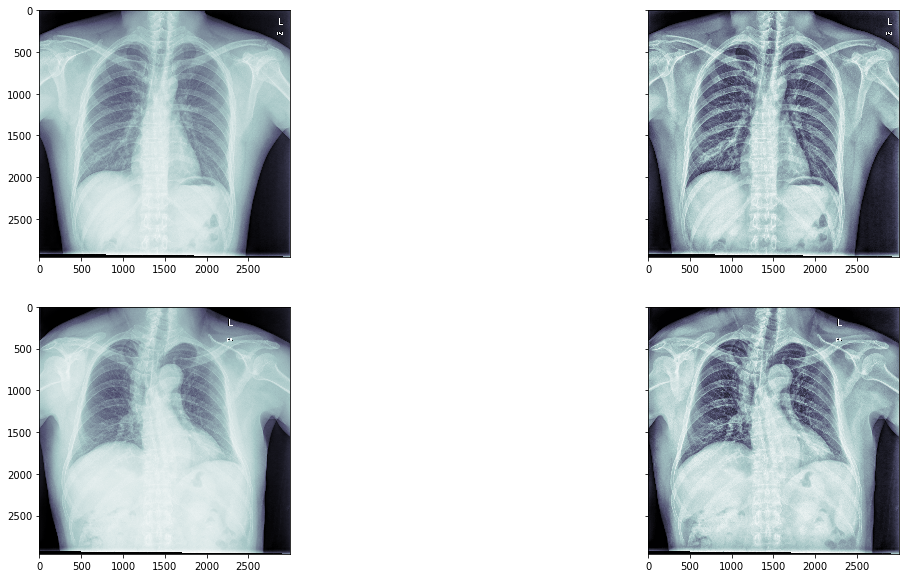

In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
start = 0 
num_img = 2 

fig, ax = plt.subplots(nrows=num_img, ncols=2, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('data/binary/normal/china_normal/*.jpeg')[start:start+num_img]):
    img = cv2.imread(file_path, 0)
    img_clahe = clahe.apply(img)
    
    ax[q, 0].imshow(img, cmap=plt.cm.bone)
    ax[q, 1].imshow(img_clahe, cmap=plt.cm.bone)

In [7]:
for source in NORMAL_SOURCES:
    num = 0
    for file_path in glob.glob(os.path.join(NORMAL_PATH, source) + '/*.jpeg'):
        img = cv2.imread(file_path, 0)
        img_clahe = clahe.apply(img)
        path = os.path.join(ENHANCED_NORMAL_PATH, source)
        cv2.imwrite('{}/{}_{}.jpeg'.format(path, source, num), img_clahe)
        num += 1

DataGenerator to rotate, shear, zoom, rescale, and fit input shape

In [9]:
datagen = ImageDataGenerator(rescale=1./255,
                             featurewise_center = True,
                             featurewise_std_normalization = True,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0.1,
                             zoom_range=0.05,
                             zca_whitening = True,
                             channel_shift_range = 0,
                             horizontal_flip = True,
                             vertical_flip = False,
                             validation_split = 0.2,
                             fill_mode='constant')

processed_normal = datagen.flow_from_directory(ENHANCED_NORMAL_PATH,
                                               target_size=IMAGE_SIZE,
                                               shuffle=False,
                                               batch_size=NUM_NORMAL,
                                               class_mode="categorical")

Found 485 images belonging to 3 classes.


In [10]:
# Grabs the dataset in matrix format X:(485, 224, 224, 3), y:(485,)
def batch_and_label(processed):
    for x_batches, y_batches in processed:
        X, y = x_batches, y_batches
        break
    return X, y
X, y = batch_and_label(processed_normal)

/Users/lcwong/opt/anaconda3/envs/py37/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/lcwong/opt/anaconda3/envs/py37/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [17]:
# Saves the final output images
for i in range(len(X)):
    plt.imsave(os.path.join(FINAL_NORMAL_PATH, 'Normal_{}.jpeg'.format(i)), X[i])
    
# Save dataset
pickle.dump(X, open("pickled_data/normal.pkl", "wb" ) )

PCA to compare normal data from different sources

Source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

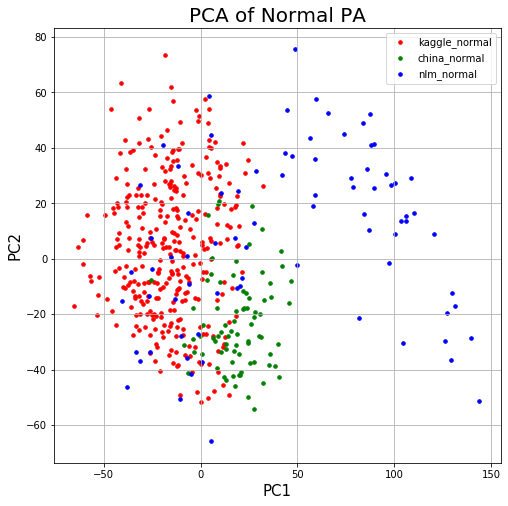

In [12]:
flatten_X = X.reshape([X.shape[0], -1])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(flatten_X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
labels = list(map(lambda i:NORMAL_SOURCES[i], [list(i).index(1) for i in y]))
principalDf['target'] = labels

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA of Normal PA', fontsize = 20)
targets = NORMAL_SOURCES
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'PC1']
               , principalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets)
ax.grid()

t-SNE to compare normal data from different sources

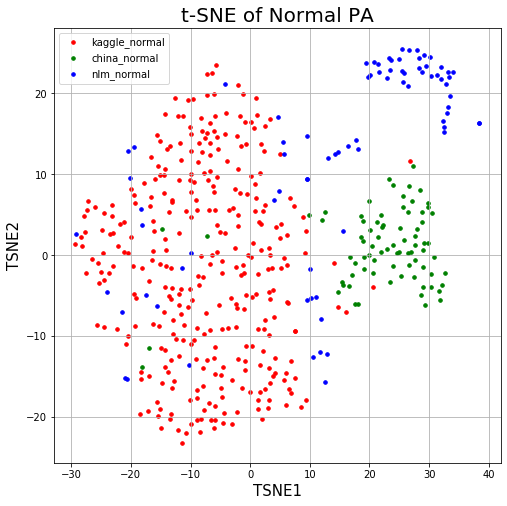

In [15]:
X_embedded = TSNE(n_components=2).fit_transform(flatten_X)
principalDf = pd.DataFrame(data = X_embedded, columns = ['TSNE1', 'TSNE2'])
labels = list(map(lambda i:NORMAL_SOURCES[i], [list(i).index(1) for i in y]))
principalDf['target'] = labels

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE1', fontsize = 15)
ax.set_ylabel('TSNE2', fontsize = 15)
ax.set_title('t-SNE of Normal PA', fontsize = 20)
targets = NORMAL_SOURCES
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'TSNE1']
               , principalDf.loc[indicesToKeep, 'TSNE2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets)
ax.grid()

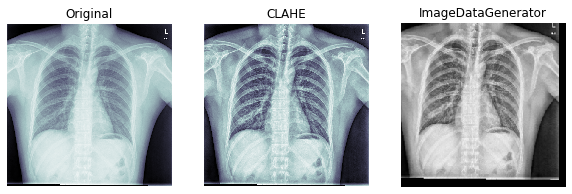

In [18]:
# Workflow Visualized
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
[axi.set_axis_off() for axi in ax.ravel()]
for q, file_path in enumerate(glob.glob('data/binary/normal/china_normal/*.jpeg')[0:1]):
    
    img = cv2.imread(file_path, 0)
    img_clahe = clahe.apply(img)
    
    ax[0].imshow(img, cmap=plt.cm.bone)
    ax[0].set_title('Original')
    ax[1].imshow(img_clahe, cmap=plt.cm.bone)
    ax[1].set_title('CLAHE')
    ax[2].imshow(pickle.load( open( "pickled_data/normal.pkl", "rb" ) )[0])
    ax[2].set_title('ImageDataGenerator')